In [14]:
import tifffile
import numpy as np

print(tifffile.__version__)
print(np.__version__)

2020.6.3
1.24.4


In [15]:
import numpy as np

def extract_mean_frame(data: np.ndarray,
                       num_v: int,
                       num_s: int,
                       num_f: int,
                       *, dtype=np.float32,
                       check=True) -> np.ndarray:
    """
    Average across ALL volumes and frames.
    Output: one mean image per stack/plane.

    Assumed order (fastest -> slowest):
        frame -> stack -> volume

    Parameters
    ----------
    data : ndarray
        Shape (T, Y, X)
    num_v : int
        Number of volumes
    num_s : int
        Number of stacks / planes
    num_f : int
        Frames per plane
    dtype : dtype
        Accumulation dtype
    check : bool
        Validate frame count

    Returns
    -------
    mean_frames : ndarray
        Shape (num_s, Y, X)
    """
    if data.ndim != 3:
        raise ValueError(f"Expected (T,Y,X), got {data.shape}")

    T, Y, X = data.shape
    expected = num_v * num_s * num_f
    if check and T != expected:
        raise ValueError(
            f"Frame mismatch: T={T}, expected {expected} "
            f"(num_v={num_v}, num_s={num_s}, num_f={num_f})"
        )

    # (T,Y,X) → (V,S,F,Y,X)
    data = data.astype(dtype, copy=False)
    reshaped = data.reshape(num_v, num_s, num_f, Y, X)

    # average over volume and frame
    mean_frames = reshaped.mean(axis=(0, 2))  # (S,Y,X)

    return mean_frames


In [16]:
# read a tiff file and plot the images

path = r"D:\data\935\20260205\stack_00001.tif"

# path = r"D:\data\724\08112024_session_00002.tif"

data = tifffile.imread(path)

print("shape:", data.shape)
print("dtype:", data.dtype)

num_v = 1
num_s = 41
num_f = 200


mean_frames = extract_mean_frame(data, num_v, num_s, num_f, dtype=np.float32, check=True)

mean_frames.shape

shape: (8200, 512, 512)
dtype: int16


(41, 512, 512)

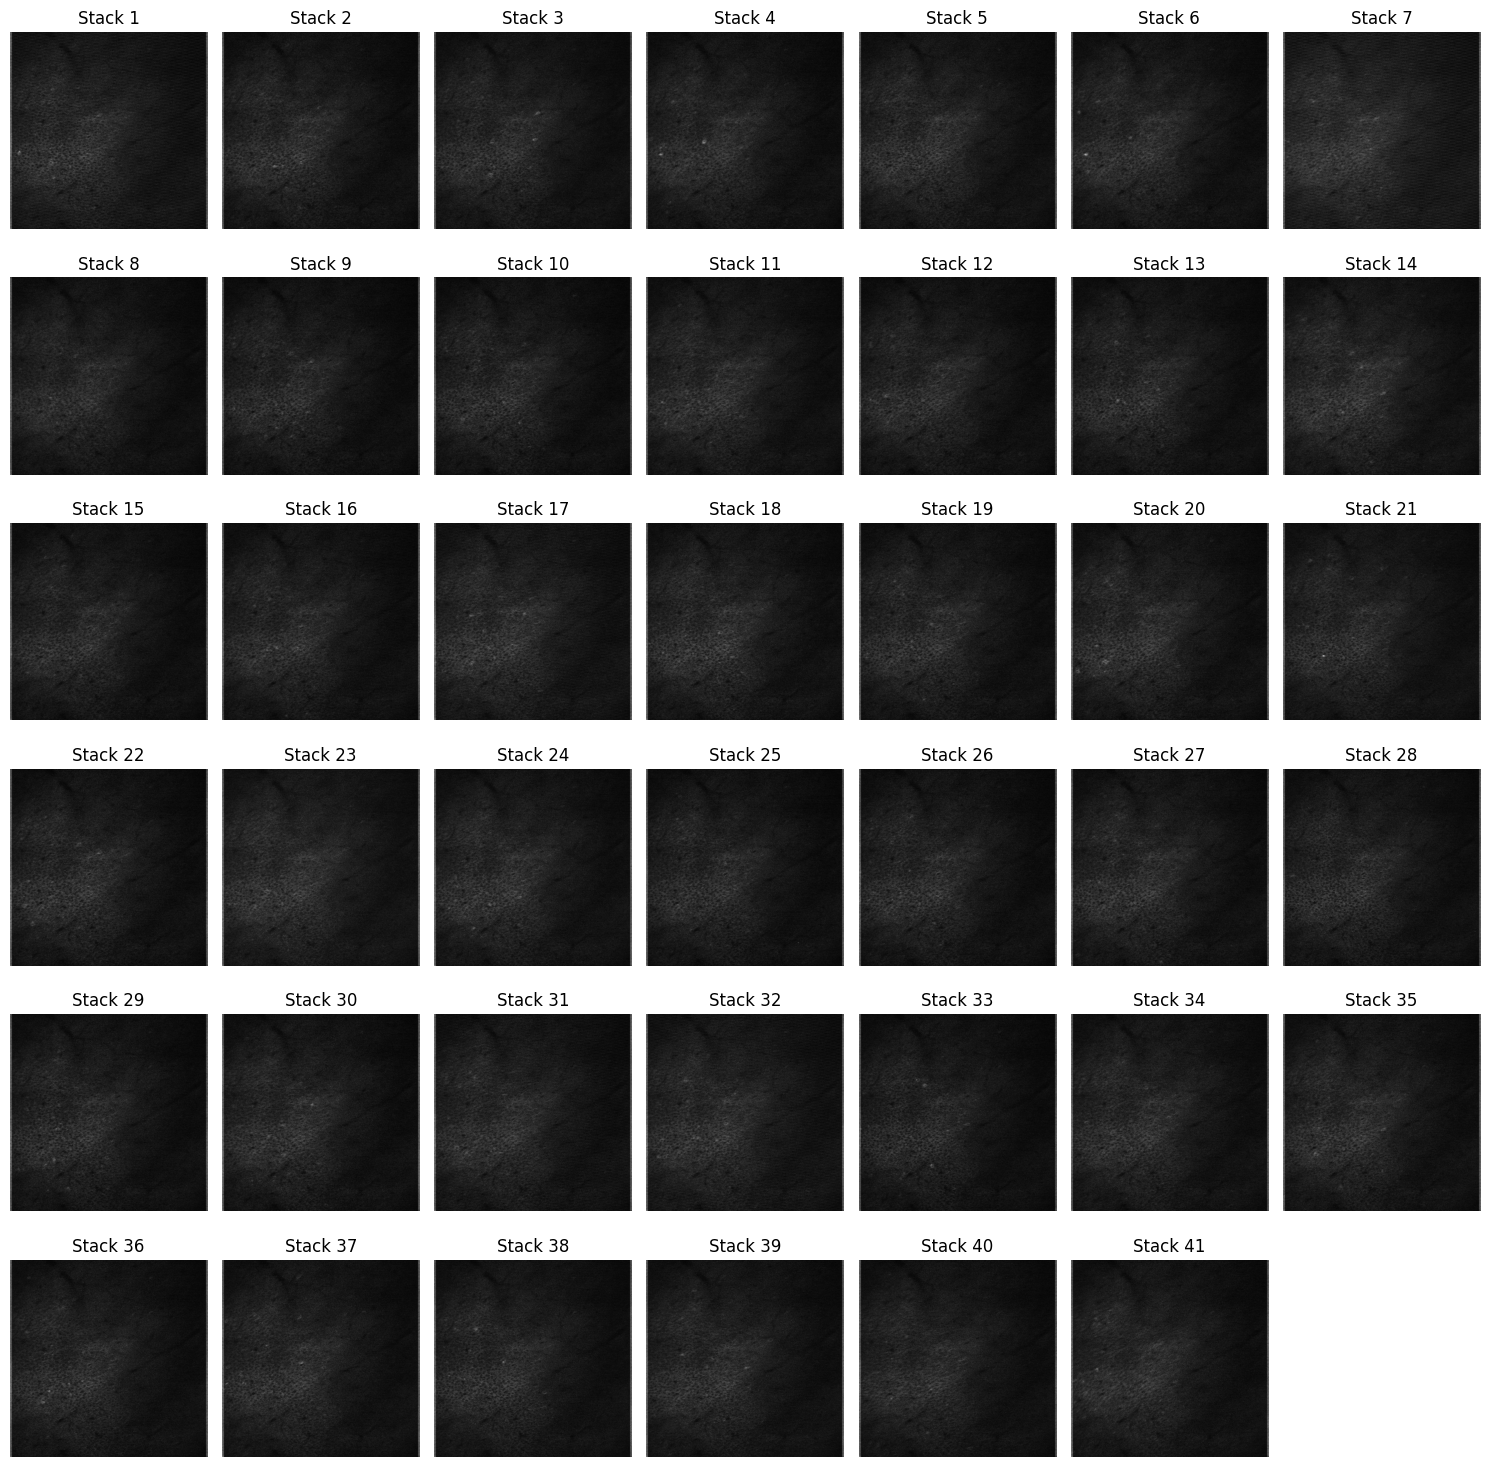

In [17]:
import matplotlib.pyplot as plt
#show 21 mean frames in a 3x7 grid
fig, axes = plt.subplots(6, 7, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < mean_frames.shape[0]:
        ax.imshow(mean_frames[i], cmap='gray')
        ax.set_title(f'Stack {i+1}')
    ax.axis('off')
plt.tight_layout()

In [3]:
# read a tiff file and plot the images

path = r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif"

# path = r"D:\data\724\08112024_session_00002.tif"

data = tifffile.imread(path)

print("shape:", data.shape)
print("dtype:", data.dtype)

num_v = 1
num_s = 21
num_f = 200


mean_frames = extract_mean_frame(data, num_v, num_s, num_f, dtype=np.float32, check=True)

mean_frames.shape


shape: (4200, 512, 512)
dtype: int16


(21, 512, 512)

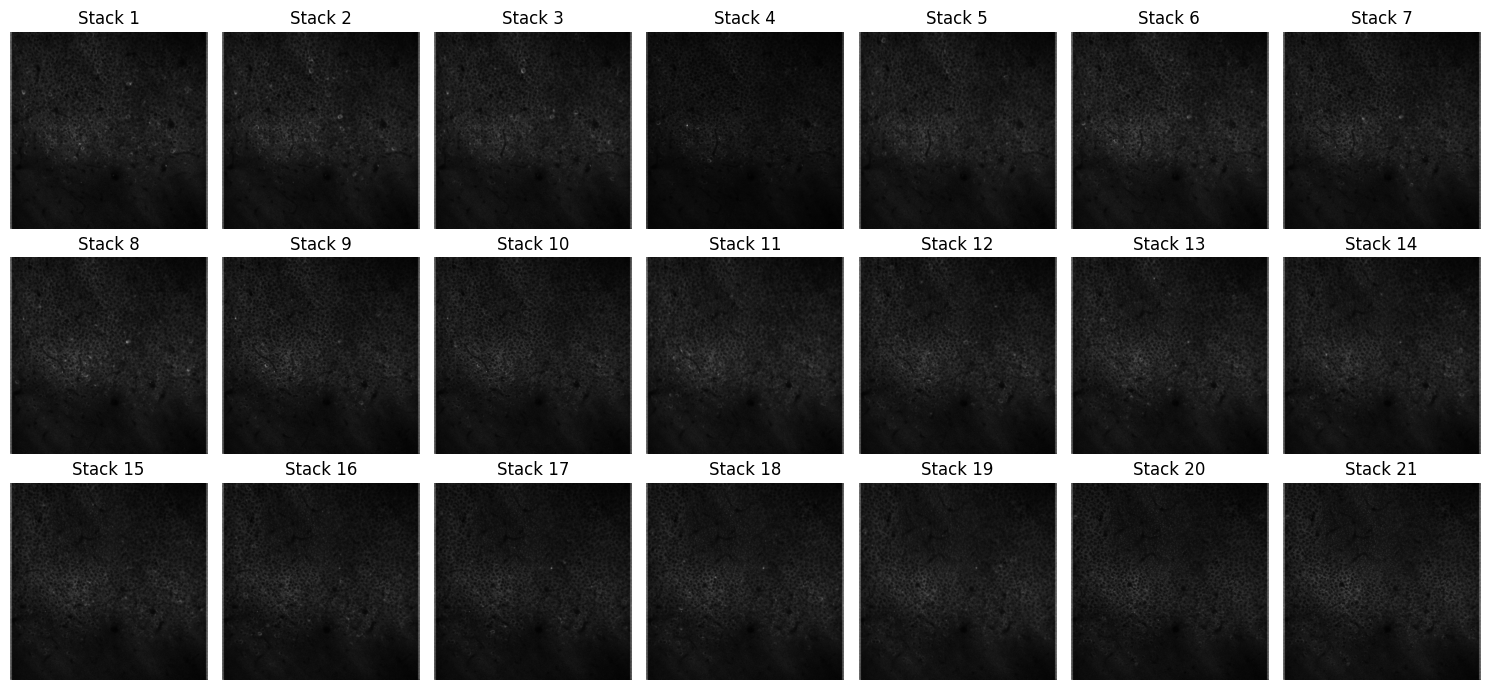

In [4]:
import matplotlib.pyplot as plt
#show 21 mean frames in a 3x7 grid
fig, axes = plt.subplots(3, 7, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    if i < mean_frames.shape[0]:
        ax.imshow(mean_frames[i], cmap='gray')
        ax.set_title(f'Stack {i+1}')
    ax.axis('off')
plt.tight_layout()

In [10]:
import tifffile as tiff

path = r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif"

with tiff.TiffFile(path) as tf:
    si_meta = tf.scanimage_metadata

si_meta

{'Description': {'frameNumbers': 1,
  'acquisitionNumbers': 1,
  'frameNumberAcquisition': 1,
  'frameTimestamps_sec': 0.0,
  'acqTriggerTimestamps_sec': -6.375e-05,
  'nextFileMarkerTimestamps_sec': -1.0,
  'endOfAcquisition': 0,
  'endOfAcquisitionMode': 0,
  'dcOverVoltage': 0,
  'epoch': [2023, 7, 27, 16, 9, 18.354],
  'auxTrigger0': [],
  'auxTrigger1': [],
  'auxTrigger2': [],
  'auxTrigger3': [],
  'I2CData': []}}

In [15]:
with tiff.TiffFile(path) as tf:
    desc1 = tf.pages[0].description   # 第一帧
    desc2 = tf.pages[1].description   # 第二帧
    desc3 = tf.pages[999].description   # 第二帧

print(desc1); print('---')
print(desc2); print('---')
print(desc3); print('---')

frameNumbers = 1
acquisitionNumbers = 1
frameNumberAcquisition = 1
frameTimestamps_sec = 0.000000000
acqTriggerTimestamps_sec = -0.000063750
nextFileMarkerTimestamps_sec = -1.000000000
endOfAcquisition = 0
endOfAcquisitionMode = 0
dcOverVoltage = 0
epoch = [2023  7 27 16  9 18.354]
auxTrigger0 = []
auxTrigger1 = []
auxTrigger2 = []
auxTrigger3 = []
I2CData = {}
---
frameNumbers = 2
acquisitionNumbers = 1
frameNumberAcquisition = 2
frameTimestamps_sec = 0.033344150
acqTriggerTimestamps_sec = -0.000063750
nextFileMarkerTimestamps_sec = -1.000000000
endOfAcquisition = 0
endOfAcquisitionMode = 0
dcOverVoltage = 0
epoch = [2023  7 27 16  9 18.354]
auxTrigger0 = []
auxTrigger1 = []
auxTrigger2 = []
auxTrigger3 = []
I2CData = {}
---
frameNumbers = 1000
acquisitionNumbers = 5
frameNumberAcquisition = 200
frameTimestamps_sec = 33.919359100
acqTriggerTimestamps_sec = 27.282763100
nextFileMarkerTimestamps_sec = -1.000000000
endOfAcquisition = 1
endOfAcquisitionMode = 0
dcOverVoltage = 0
epoch = [

In [18]:
import tifffile as tiff
import numpy as np
import re

_num_re = re.compile(r"^[+-]?\d+(\.\d+)?([eE][+-]?\d+)?$")

def _parse_value(v: str):
    v = v.strip()

    # Empty list/dict
    if v == "[]":
        return []
    if v == "{}":
        return {}

    # Bracket array like: [2023  7 27 16  9 18.354]
    if v.startswith("[") and v.endswith("]"):
        inner = v[1:-1].strip()
        if inner == "":
            return []
        parts = re.split(r"[\s,]+", inner)
        out = []
        for p in parts:
            if p == "":
                continue
            if _num_re.match(p):
                # int if looks like int, else float
                out.append(int(p) if re.match(r"^[+-]?\d+$", p) else float(p))
            else:
                out.append(p)
        return out

    # Number
    if _num_re.match(v):
        return int(v) if re.match(r"^[+-]?\d+$", v) else float(v)

    # Fallback: string
    return v

def parse_scanimage_description(desc: str) -> dict:
    """
    Parse ScanImage per-frame ImageDescription text into a dict.
    Only parses the first block before '---' (one page should be one block).
    """
    d = {}
    # Some descriptions may contain multiple blocks separated by ---; for a single page we want the first.
    block = desc.split('---', 1)[0]
    for line in block.splitlines():
        line = line.strip()
        if not line or line.startswith('%'):
            continue
        if '=' not in line:
            continue
        k, v = line.split('=', 1)
        d[k.strip()] = _parse_value(v)
    return d

def get_si_frame_times_from_pages(path):
    ts = []
    epoch = None

    with tiff.TiffFile(path) as tf:
        for i, page in enumerate(tf.pages):
            desc = page.description

            if isinstance(desc, dict):
                # 有些版本 tifffile 会直接给 dict（你之前看到的那种）
                dd = desc.get("Description", desc)
            elif isinstance(desc, str):
                dd = parse_scanimage_description(desc)
            else:
                raise TypeError(f"Page {i}: unexpected description type: {type(desc)}")

            if epoch is None and "epoch" in dd:
                epoch = dd["epoch"]

            if "frameTimestamps_sec" not in dd:
                raise KeyError(f"Page {i}: missing frameTimestamps_sec. Keys: {list(dd.keys())[:20]}...")

            ts.append(float(dd["frameTimestamps_sec"]))

    return np.asarray(ts, dtype=np.float64), epoch


In [ ]:
# path = r"C:\Users\BurgessLab\Desktop\SM2PCode\2D2P\Data\stack27072023_00002.tif"

path = r"D:\data\ImagingData\TIFF Export\online_grab_CH2_20260127_124607.tif"

ts_sec, epoch = get_si_frame_times_from_pages(path)

print("epoch:", epoch)
print("frame1 t:", ts_sec[0])
print("frame2 t:", ts_sec[1])
print(ts_sec)


epoch: [2023, 7, 27, 16, 9, 18.354]
frame1 t: 0.0
frame2 t: 0.03334415
[0.00000000e+00 3.33441500e-02 6.66883500e-02 ... 1.43131037e+02
 1.43164391e+02 1.43197744e+02]


In [31]:
np.diff(ts_sec).mean()

0.03410282077875684

In [33]:
4200*0.0341028

143.23176

In [3]:
import datetime as dt
from pathlib import Path

path = Path(r"C:\\Users\\BurgessLab\\Desktop\\SM2PCode\\2D2P\\Data\\rotary_stream_20260205_123621.txt")

dt_list = []
mono_list = []

with path.open("r", encoding="utf-8") as f:
    header = f.readline()
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 3:
            continue
        dt_str = parts[0] + " " + parts[1]
        mono_str = parts[2]

        try:
            t = dt.datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
        except ValueError:
            try:
                t = dt.datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
            except ValueError:
                continue

        try:
            mono = float(mono_str)
        except ValueError:
            continue

        dt_list.append(t)
        mono_list.append(mono)

if not dt_list:
    raise ValueError("No valid rows")

t0 = dt_list[0]
m0 = mono_list[0]

dt_offset = [(t - t0).total_seconds() for t in dt_list]
mono_offset = [m - m0 for m in mono_list]

diff = [a - b for a, b in zip(dt_offset, mono_offset)]

for i in range(len(diff)):
    print(i, dt_offset[i], mono_offset[i], diff[i])


0 0.0 0.0 0.0
1 0.035 0.03585300000003144 -0.0008530000000314397
2 0.049 0.04912900000005038 -0.00012900000005038048
3 0.06 0.06071700000001101 -0.0007170000000110144
4 0.072 0.0721470000000295 -0.00014700000002949853
5 0.109 0.10963600000002316 -0.0006360000000231597
6 0.142 0.14236400000004323 -0.0003640000000432464
7 0.145 0.1457690000000298 -0.0007690000000298014
8 0.175 0.175907000000052 -0.0009070000000520051
9 0.182 0.18259100000000217 -0.0005910000000021731
10 0.192 0.19255400000002965 -0.0005540000000296419
11 0.202 0.20208900000000085 -8.900000000083841e-05
12 0.217 0.2175380000000473 -0.0005380000000473062
13 0.222 0.22260400000004665 -0.0006040000000466506
14 0.232 0.2327820000000429 -0.0007820000000428873
15 0.238 0.23801300000002357 -1.3000000023577485e-05
16 0.243 0.2433470000000284 -0.0003470000000284079
17 0.249 0.24902700000001232 -2.7000000012322722e-05
18 0.253 0.2534500000000435 -0.0004500000000434712
19 0.263 0.2636100000000283 -0.0006100000000283101
20 0.268 0.26

In [13]:
max(diff)


9.299999995704411e-05

(array([712., 706., 728., 710., 658., 645., 714., 670., 699., 683.]),
 array([-9.15000000e-04, -8.14200000e-04, -7.13400000e-04, -6.12600000e-04,
        -5.11800000e-04, -4.11000000e-04, -3.10200000e-04, -2.09400000e-04,
        -1.08600000e-04, -7.80000004e-06,  9.30000000e-05]),
 <BarContainer object of 10 artists>)

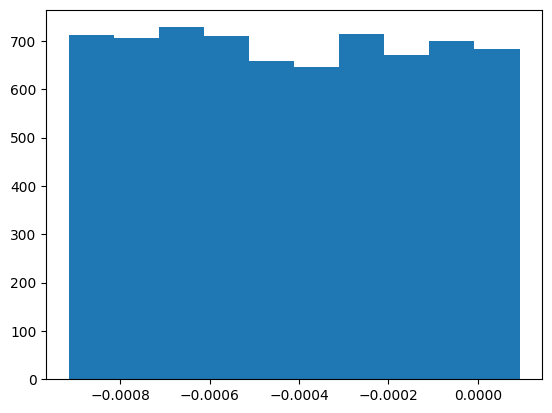

In [7]:

import matplotlib.pyplot as plt
plt.hist(diff)

In [18]:
from datetime import datetime, timedelta

def infer_frame_datetimes(path):
    """
    Infer per-frame acquisition datetimes from ScanImage TIFF pages.

    Returns:
        datetimes: list[datetime]
        epoch: raw epoch metadata (if present)
    """
    ts, epoch = get_si_frame_times_from_pages(path)
    if epoch is None:
        raise ValueError("epoch not found in TIFF ImageDescription metadata")

    base = None
    if isinstance(epoch, (list, tuple, np.ndarray)):
        if len(epoch) < 6:
            raise ValueError(f"epoch list too short: {epoch}")
        year, month, day, hour, minute, sec = epoch[:6]
        sec_int = int(sec)
        usec = int(round((sec - sec_int) * 1e6))
        base = datetime(int(year), int(month), int(day), int(hour), int(minute), sec_int, usec)
    elif isinstance(epoch, (int, float)):
        # Treat numeric epoch as Unix seconds if reasonable.
        if epoch > 1e9:
            base = datetime.fromtimestamp(epoch)
        else:
            raise ValueError(f"unexpected numeric epoch: {epoch}")
    elif isinstance(epoch, str):
        # Try common formats.
        for fmt in ("%Y-%m-%d %H:%M:%S.%f", "%Y-%m-%d %H:%M:%S"):
            try:
                base = datetime.strptime(epoch, fmt)
                break
            except ValueError:
                continue
        if base is None:
            raise ValueError(f"unrecognized epoch string: {epoch}")
    else:
        raise TypeError(f"unsupported epoch type: {type(epoch)}")

    datetimes = [base + timedelta(seconds=float(t)) for t in ts]
    return datetimes, epoch


In [20]:
path = r"D:\data\935\20260205\stack_00001.tif"

datetimes, epoch = infer_frame_datetimes(path)

print("epoch:", epoch)
print("frame 1 datetime:", datetimes[0])

epoch: [2026, 2, 5, 15, 49, 33.89]
frame 1 datetime: 2026-02-05 15:49:33.890000


Text(0.5, 1.0, 'Frame datetime offsets from first frame (Motor not FastZ)')

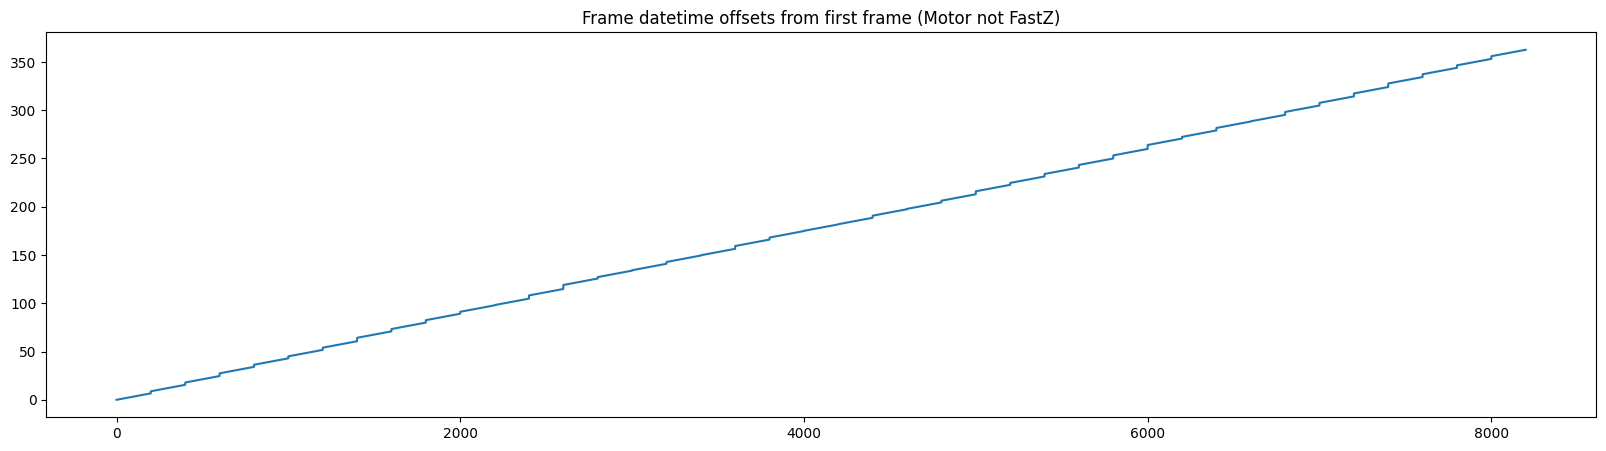

In [17]:
#plot datetime offsets from first frame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 5))
offsets = [(dt - datetimes[0]).total_seconds() for dt in datetimes]
ax.plot(offsets)
ax.set_title("Frame datetime offsets from first frame (Motor not FastZ)")



In [15]:
datetimes

[datetime.datetime(2026, 2, 5, 15, 49, 33, 890000),
 datetime.datetime(2026, 2, 5, 15, 49, 33, 923364),
 datetime.datetime(2026, 2, 5, 15, 49, 33, 956729),
 datetime.datetime(2026, 2, 5, 15, 49, 33, 990093),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 23458),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 56822),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 90186),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 123551),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 156915),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 190280),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 223644),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 257008),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 290373),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 323737),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 357102),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 390466),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 423831),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 457195),
 datetime.datetime(2026, 2, 5, 15, 49, 34, 490559),
 datetime.datet

In [8]:

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# notebook/ 的父目录
root = Path.cwd().parent  # 如果当前工作目录就是 notebook 目录
# 或者：root = Path(__file__).resolve().parent.parent  # 在脚本里用

sys.path.insert(0, str(root))

from utils_io import get_scanimage_frame_times

#auto reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tif_path = r"D:\data\935\20260205\stack_00001.tif"

tA_rel, tA_wall = get_scanimage_frame_times(tif_path)

print("acq  :", tA_wall[:3])

acq  : ['2026-02-05T15:49:33.923364400' '2026-02-05T15:49:33.956728800'
 '2026-02-05T15:49:33.990093200']


In [11]:
tA_rel

array([3.33644000e-02, 6.67288000e-02, 1.00093200e-01, ...,
       3.62574296e+02, 3.62607664e+02, 3.62641031e+02])

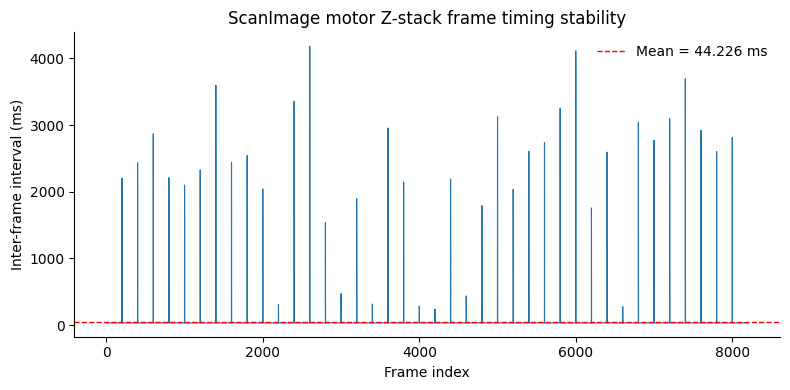

In [15]:
dt = np.diff(tA_rel) * 1000 # convert to ms
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(dt, lw=0.8)

ax.set_xlabel("Frame index")
ax.set_ylabel("Inter-frame interval (ms)")
ax.set_title("ScanImage motor Z-stack frame timing stability")

# 显示统计量
mean_dt = dt.mean()
std_dt  = dt.std()

ax.axhline(mean_dt, color="r", ls="--", lw=1,
           label=f"Mean = {mean_dt:.3f} ms")

ax.legend(frameon=False)

# 美化
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [14]:
dt.max()

4.184787800000009